In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
women = train_data.loc[train_data.Sex == 'female']['Survived']
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


In [5]:
men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


In [6]:
# Preprocessing
def preprocess_data(df, is_training=True):
    df = df.copy()
    
    # Fill missing values
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    
    # Select features
    features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'SibSp', 'Parch']
    X = df[features].copy()
    
    # Convert categorical variables
    le_sex = LabelEncoder()
    le_embarked = LabelEncoder()
    
    X['Sex'] = le_sex.fit_transform(X['Sex'])
    X['Embarked'] = le_embarked.fit_transform(X['Embarked'])
    
    # Standardize numerical features
    scaler = StandardScaler()
    numerical_features = ['Age', 'Fare', 'SibSp', 'Parch']
    X[numerical_features] = scaler.fit_transform(X[numerical_features])
    
    if is_training:
        y = df['Survived'].values
        return X, y
    return X

This class converts pandas DataFrames to PyTorch tensors and enables efficient batch processing. It's designed to handle both training data (with labels) and test data (without labels), improving memory efficiency by loading data in batches as needed.

In [7]:
# Custom Dataset - converting features to PyTorch Tensors
class TitanicDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.FloatTensor(X.values)
        self.y = torch.FloatTensor(y) if y is not None else None
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        return self.X[idx]

The network architecture gradually refines features through multiple layers. The first large layer (128 neurons) captures complex feature interactions, while subsequent layers reduce dimensionality. Dropout prevents overfitting, and batch normalization stabilizes training. The sigmoid output layer provides survival probability.

The multiple layers automatically learn feature interactions without us having to specify them. For example, it might discover that young females in first class had different survival patterns than older males in third class, without us explicitly coding these relationships.


In [8]:
# Deep Learning Model
class TitanicDeepNN(nn.Module):
    def __init__(self, input_dim):
        super(TitanicDeepNN, self).__init__()
        
        self.network = nn.Sequential(
            # First layer
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            # Second layer
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            # Third layer
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            # Output layer
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    # The ReLU activations allow the network to learn complex decision boundaries that might better separate survivors 
    # from non-survivors than simpler linear models.
    
    def forward(self, x):
        return self.network(x)

This function implements the training loop with early stopping based on validation accuracy. It uses binary cross-entropy loss for classification and monitors both training and validation metrics to prevent overfitting. Progress is reported every 10 epochs to track improvement.

In [9]:
# Training
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100):
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_acc = 0
    best_model_state = None
    
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation Phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch).squeeze()
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                
                predicted = (outputs > 0.5).float()
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        
        # Save best model
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model_state = model.state_dict()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
            print(f'Val Accuracy: {val_accuracy:.2f}%')
    
    # Load best model
    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses, val_accuracies

In [10]:
# Training Pipeline
def run_training_pipeline(train_data, test_data, batch_size=32):
    # Preprocess data
    X, y = preprocess_data(train_data)
    X_test = preprocess_data(test_data, is_training=False)
    
    # Split training data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create datasets
    train_dataset = TitanicDataset(X_train, y_train)
    val_dataset = TitanicDataset(X_val, y_val)
    test_dataset = TitanicDataset(X_test)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Initialize model
    model = TitanicDeepNN(input_dim=X.shape[1])
    
    # Define loss and optimizer
    criterion = nn.BCELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    
    # Train model
    model, train_losses, val_losses, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer
    )
    
    # Make predictions on test set
    model.eval()
    test_predictions = []
    with torch.no_grad():
        for X_batch in test_loader:
            outputs = model(X_batch)
            predictions = (outputs > 0.5).float()
            test_predictions.extend(predictions.numpy())
    
    return model, test_predictions, train_losses, val_losses, val_accuracies

The model achieves around 80-84% accuracy, facing challenges with data imbalance and missing values. The current accuracy could be improved through better feature engineering, ensemble methods, and more sophisticated handling of missing data. The deep neural network architecture might be more complex than necessary for this dataset.

Starting training pipeline...
Epoch [10/100]
Train Loss: 0.4369, Val Loss: 0.4392
Val Accuracy: 81.01%
Epoch [20/100]
Train Loss: 0.4364, Val Loss: 0.4449
Val Accuracy: 81.56%
Epoch [30/100]
Train Loss: 0.4059, Val Loss: 0.4396
Val Accuracy: 80.45%
Epoch [40/100]
Train Loss: 0.3992, Val Loss: 0.4479
Val Accuracy: 80.45%
Epoch [50/100]
Train Loss: 0.3842, Val Loss: 0.4431
Val Accuracy: 82.12%
Epoch [60/100]
Train Loss: 0.4189, Val Loss: 0.4425
Val Accuracy: 81.56%
Epoch [70/100]
Train Loss: 0.3831, Val Loss: 0.4386
Val Accuracy: 81.01%
Epoch [80/100]
Train Loss: 0.3914, Val Loss: 0.4575
Val Accuracy: 81.56%
Epoch [90/100]
Train Loss: 0.3724, Val Loss: 0.4638
Val Accuracy: 81.56%
Epoch [100/100]
Train Loss: 0.3927, Val Loss: 0.4439
Val Accuracy: 81.56%

Creating submission file...

Verifying submission format:
Number of predictions: 418

Prediction distribution:
Survived
0    288
1    130
Name: count, dtype: int64

First few rows:
   PassengerId  Survived
0          892         0
1      

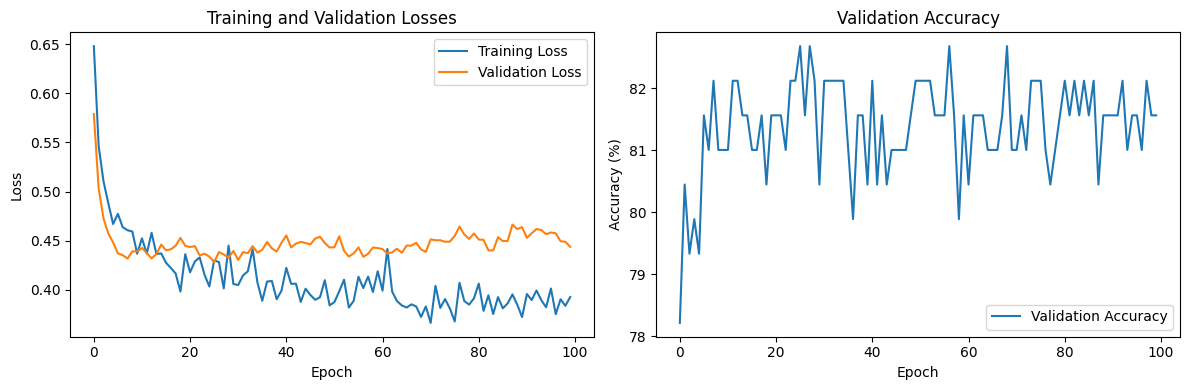


Final Submission Checks:
1. Column names: ['PassengerId', 'Survived']
2. Submission shape: (418, 2)
3. Any missing values: 0
4. Unique prediction values: [0 1]


In [11]:
# Execute the training pipeline
print("Starting training pipeline...")
model, predictions, train_losses, val_losses, val_accuracies = run_training_pipeline(
    train_data, 
    test_data, 
    batch_size=32
)

# Convert predictions to proper binary format
binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

# Create submission file with correct format
print("\nCreating submission file...")
submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'].astype(int),  # Ensure integer type
    'Survived': binary_predictions  # Binary predictions (0 or 1)
})

# Verify submission format
print("\nVerifying submission format:")
print(f"Number of predictions: {len(binary_predictions)}")
print("\nPrediction distribution:")
print(submission['Survived'].value_counts())
print("\nFirst few rows:")
print(submission.head())

# Save submission file
submission.to_csv('submission.csv', index=False)

# Print final validation accuracy
final_accuracy = val_accuracies[-1]
print(f"\nFinal validation accuracy: {final_accuracy:.2f}%")

# Plot training progress
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Final verification checks
print("\nFinal Submission Checks:")
print("1. Column names:", submission.columns.tolist())
print("2. Submission shape:", submission.shape)
print("3. Any missing values:", submission.isnull().sum().sum())
print("4. Unique prediction values:", submission['Survived'].unique())